# Potential Surface Temperature

## Imports

In [1]:
from reader import Reader
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from datetime import datetime
from datetime import date as date_creator
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numba import njit
import pandas as pd
import os 
from numba import jit
from scipy.interpolate import griddata

%matplotlib inline

C:\Users\barroisl\AppData\Local\Temp\ipykernel_2564\3735118499.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Netatmo

In [336]:
import pandas as pd
import os

def netatmo_txt(text_file):
    # Read the text file and split lines
    with open(text_file, 'r') as file:
        lines = file.readlines()

    # Extract column names from the first line (assuming it contains column headers)
    column_names = ['id','lon','lat','alt','Temp','hu','Tbrut','hubrut','t0','t1']
    # Create an empty dictionary to store data for each column
    data = {col: [] for col in column_names}

    # Iterate over the remaining lines to extract data for each column
    for line in lines[1:]:
        values = line.strip().split(' ')
        for col, val in zip(column_names, values):
            if col != 'id' :
                data[col].append(float(val))
            else :
                data[col].append(val)

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    return df

def all_txt(directory):
    
    dfs = []

    text_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    for text_file in text_files:
        file_path = os.path.join(directory,text_file)
        # Read each text file into a DataFrame
        df = netatmo_txt(file_path)  
        dfs.append(df)
        
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

In [363]:
text_file = 'C:/Users/barroisl/Documents/Stage_Léo/Stations/Observations_NETATMO/TEMP_HUM_RELATIVE/19-08-2023/Netatmo_id_lon_lat_alt_t_hu_tbrut_hubrut_t0_t1_20230819000000.txt'

df_net = netatmo_txt(text_file)

print(df_net)

                     id       lon        lat     alt  Temp    hu  Tbrut  \
0     70:ee:50:00:0a:02  5.341308  45.893487   215.0   NaN   NaN   27.1   
1     70:ee:50:00:0a:9e  5.661396  45.204901   211.0   NaN   NaN   25.9   
2     70:ee:50:00:0a:da  5.750908  45.277225  1124.0  20.2  50.0   21.9   
3     70:ee:50:00:0b:c8  5.860382  44.269365   619.0   NaN   NaN   26.6   
4     70:ee:50:00:0c:14  5.179655  45.613582   228.0  25.5  39.0   25.6   
...                 ...       ...        ...     ...   ...   ...    ...   
5177  70:ee:50:a5:ad:82  6.630306  43.778445  1052.0  15.6  62.0   17.4   
5178  70:ee:50:a5:b6:c0  7.581954  44.056056   741.0  20.0  55.0   21.2   
5179  70:ee:50:a5:b7:62  6.128310  46.173246   397.0   NaN   NaN   23.0   
5180  70:ee:50:a5:be:50  7.012982  43.706193   345.0  24.1  50.0   27.4   
5181  70:ee:50:ff:ff:18  6.137374  45.940334   500.0  19.6  59.0   19.0   

      hubrut            t0            t1  
0       40.0  1.692403e+09  1.692404e+09  
1       43.0 

In [339]:
directory_netatmo = 'C:/Users/barroisl/Documents/Stage_Léo/Stations/Observations_NETATMO/TEMP_HUM_RELATIVE/'

dfs = all_txt(directory_netatmo)

print(dfs)

ValueError: No objects to concatenate

In [8]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

df_cropped = dfs[(dfs['lat'] >=img_extent[2]) & (dfs['lat'] <= img_extent[3]) &
              (dfs['lon'] >= img_extent[0]) & (dfs['lon'] <= img_extent[1])]

print(df_cropped)

                      id       lon        lat     alt     T    hu  Tbrut  \
0      70:ee:50:00:0a:02  5.341308  45.893487   215.0   NaN   NaN   29.6   
1      70:ee:50:00:0a:9e  5.661396  45.204901   211.0   NaN   NaN   28.1   
2      70:ee:50:00:0a:da  5.750908  45.277225  1124.0  21.3  47.0   22.9   
3      70:ee:50:00:0b:c8  5.860382  44.269365   619.0   NaN   NaN   28.8   
4      70:ee:50:00:0c:14  5.179655  45.613582   228.0  28.3   NaN   28.1   
...                  ...       ...        ...     ...   ...   ...    ...   
10512  70:ee:50:a5:b6:c0  7.581954  44.056056   741.0  20.7   NaN   21.9   
10513  70:ee:50:a5:b7:62  6.128310  46.173246   397.0   NaN   NaN   23.3   
10514  70:ee:50:a5:be:50  7.012982  43.706193   345.0  24.7  48.0   27.9   
10515  70:ee:50:ff:ff:18  6.137374  45.940334   500.0  20.5  56.0   19.9   
10516  70:ee:50:ff:ff:4a  5.547736  45.413960   478.0   NaN   NaN    NaN   

       hubrut            t0            t1  
0        36.0  1.692396e+09  1.692397e+09  

## Météo France et partenaires

In [20]:
import pandas as pd
import os
from datetime import datetime

def convert_to_datetime(datetime_string):
    datetime_obj = datetime.strptime(datetime_string, '%Y%m%d%H%M%S')
    return datetime_obj

def is_a_letter_in(string) :
    res = []
    for i in string :
        res.append(i.isalpha())
    if True in res :
        return True
    else :
        return False

def test_string(s,name_col):
    if '\\' in s:
        return np.nan
    elif s.strip() == '':
        return np.nan  
    elif s.isalpha() :
        return s
    elif name_col == 'date' :
        return convert_to_datetime(s)
    else:
        try:
            if float(s) == 999999 :
                return np.nan
            else : 
                return float(s)
        except ValueError:
            return s

def meteo_france_txt(text_file):
    # Read the text file and split lines
    with open(text_file, 'r') as file:
        lines = file.readlines()

    # Extract column names from the first line (assuming it contains column headers)
    column_names = ['date','type','n°OMM','n°Météo-France','nom_sta','lon','lat',
                    'altitude_baromètre (m)','altitude_station (m)','pression (Pa)',
                   'pr_nmer', 'T-1.5','T_r','hu','precip_1h','dir_vent_moy',
                   'u_moy','u_inst','dir_vent_inst','u_vent_inst_max']
    # Create an empty dictionary to store data for each column
    data = {col: [] for col in column_names}

    # Iterate over the remaining lines to extract data for each column
    for line in lines[1:]:
        values = line.strip().split(';')
        if len(column_names) == len(values) -1 : 
            for col, val in zip(column_names, values):
                data[col].append(test_string(val,col))

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    return df

def all_txt_mf(directory):
    
    days = ['19-08-2023/','20-08-2023/','21-08-2023/','22-08-2023/','23-08-2023/','24-08-2023/']

    dfs = []
    for i in range(len(days)):
        text_files = [f for f in os.listdir(directory+days[i]) if f.endswith('.txt')]
        for text_file in text_files:
            file_path = os.path.join(directory+days[i],text_file)
            # Read each text file into a DataFrame
            df = meteo_france_txt(file_path)  
            dfs.append(df)
            
        concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

In [21]:
text_file_mf = 'C:/Users/barroisl/Documents/Stage_Léo/Stations/Observations_Meteo-France_et_partenaires/19-08-2023/MF_ALL_OBS_with_WIND_20230819000000_1H.txt'

df_mf = meteo_france_txt(text_file_mf)

print(df_mf)

                     date  type    n°OMM  n°Météo-France        nom_sta  \
0     2023-08-19 00:00:00  CALH      NaN       1027003.0            NaN   
1     2023-08-19 00:00:00  CALH      NaN       1033002.0            NaN   
2     2023-08-19 00:00:00  CALH      NaN       1034004.0            NaN   
3     2023-08-19 00:00:00  CALH      NaN       1064001.0            NaN   
4     2023-08-19 00:00:00  CALH      NaN       1071001.0            NaN   
...                   ...   ...      ...             ...            ...   
11316 2023-08-19 00:40:00   SOL   3882.0             NaN            NaN   
11317 2023-08-19 00:40:00   SOL   3904.0             NaN            NaN   
11318 2023-08-19 00:40:00   SOL   3915.0             NaN            NaN   
11319 2023-08-19 00:40:00   SOL   3930.0             NaN            NaN   
11320 2023-08-19 00:43:00   SOL  14431.0             NaN  ZADAR/ZEMUNIK   

            lon       lat  altitude_baromètre (m)  altitude_station (m)  \
0       5.10667  45.8330

In [22]:
directory_mf = 'C:/Users/barroisl/Documents/Stage_Léo/Stations/Observations_Meteo-France_et_partenaires/'

dfs_mf = all_txt_mf(directory_mf)

dfs_mf.head(10)

,date,type,n°OMM,n°Météo-France,nom_sta,lon,lat,altitude_baromètre (m),altitude_station (m),pression (Pa),pr_nmer,T-1.5,T_r,hu,precip_1h,dir_vent_moy,u_moy,u_inst,dir_vent_inst,u_vent_inst_max
0,2023-08-19,CALH,NaN,1027003.0,NaN,5.10667,45.83300,196.0,NaN,NaN,NaN,292.65,287.05,70.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-19,CALH,NaN,1033002.0,NaN,5.81417,46.08650,350.0,NaN,NaN,NaN,289.95,286.05,78.0,0.0,270.0,0.7,280.0,1.6,NaN
2,2023-08-19,CALH,NaN,1034004.0,NaN,5.68800,45.76933,330.0,NaN,NaN,NaN,295.75,285.95,54.0,0.0,10.0,0.6,30.0,1.1,NaN
3,2023-08-19,CALH,NaN,1064001.0,NaN,5.48717,45.77717,281.0,NaN,NaN,NaN,293.95,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2023-08-19,CALH,NaN,1071001.0,NaN,6.08033,46.31033,507.0,NaN,NaN,NaN,295.25,284.35,50.0,0.0,320.0,1.5,300.0,2.7,NaN
5,2023-08-19,CALH,NaN,1072001.0,NaN,5.28767,46.20433,260.0,NaN,NaN,NaN,299.35,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6,2023-08-19,CALH,NaN,1089001.0,NaN,5.32933,45.97650,250.0,252.0,98570.0,101440.0,297.55,285.15,46.0,0.0,140.0,2.7,140.0,5.5,NaN
7,2023-08-19,CALH,NaN,1104002.0,NaN,5.86717,46.22167,580.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,2023-08-19,CALH,NaN,1143002.0,NaN,6.13967,46.34150,467.0,NaN,NaN,NaN,288.65,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
9,2023-08-19,CALH,NaN,1185004.0,NaN,5.59817,45.97967,805.0,NaN,NaN,NaN,288.83,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


## Temperature potentielle

In [340]:
def potential_temp(img_extent,df_mf,df_net,type_sta):
    
    if type_sta == 'mf':

        df_mf = df_mf[(df['lat'] >=img_extent[2]) & (df_mf['lat'] <= img_extent[3]) &
              (df_mf['lon'] >= img_extent[0]) & (df_mf['lon'] <= img_extent[1])]
        df_mf.dropna()

        lat = df_mf['lat']
        lon = df_mf['lon']
        pression = df_mf['pression (Pa)']
        p0 = 100000
        T = df_mf['T-1.5']
        pot_temp = []
        indexs = df_mf.index
        for i in indexs:
            pot_temp.append(T[i]*(p0/pression[i])**(2/7))
        
        lon_interp = np.linspace(img_extent[0], img_extent[1], 100)
        lat_interp = np.linspace(img_extent[2], img_extent[3], 100)
        lon_interp, lat_interp = np.meshgrid(lon_interp, lat_interp)
        pot_temp_interp = griddata((lon, lat), pot_temp, (lon_interp, lat_interp), method='nearest')
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(lon,lat,c = pot_temp,s=1, cmap = 'coolwarm')
        plt.colorbar()
    
        plt.subplot(1, 2, 2)
        plt.contourf(lon_interp,lat_interp,pot_temp_interp,levels=100, cmap = 'coolwarm')
        plt.colorbar()

    elif type_sta == 'net':  

        df_net = df_net[(df['lat'] >=img_extent[2]) & (df_net['lat'] <= img_extent[3]) &
              (df_net['lon'] >= img_extent[0]) & (df_net['lon'] <= img_extent[1])]
        df_net.dropna()

        lat = df_net['lat']
        lon = df_net['lon']
        alt = df_net['alt']
        rho = 1
        g = 9.81
        p0 = 100000
        T = df_net['Temp']
        pot_temp = []
        pression = []
        indexs = df_net.index
        for i in indexs:
            pression.append(p0-rho*g*alt[i])
            pot_temp.append((T[i]+273.15)*(p0/pression[-1])**(2/7))
        
        lon_interp = np.linspace(img_extent[0], img_extent[1], 1000)
        lat_interp = np.linspace(img_extent[2], img_extent[3], 1000)
        lon_interp, lat_interp = np.meshgrid(lon_interp, lat_interp)
        pot_temp_interp = griddata((lon, lat), pot_temp, (lon_interp, lat_interp), method='linear')
        
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(lon,lat,c = pot_temp,s=1, cmap = 'coolwarm')
        plt.colorbar()
    
        plt.subplot(1, 2, 2)
        plt.contourf(lon_interp,lat_interp,pot_temp_interp,levels=1000, cmap = 'coolwarm')
        plt.colorbar()

    elif type_sta == 'both':

        df_mf = df_mf[(df_mf['lat'] >=img_extent[2]) & (df_mf['lat'] <= img_extent[3]) &
              (df_mf['lon'] >= img_extent[0]) & (df_mf['lon'] <= img_extent[1])]
        df_mf.dropna()

        df_net = df_net[(df['lat'] >=img_extent[2]) & (df_net['lat'] <= img_extent[3]) &
              (df_net['lon'] >= img_extent[0]) & (df_net['lon'] <= img_extent[1])]
        df_net.dropna()

        lat_net = df_net['lat'].values
        lon_net = df_net['lon'].values
        alt_net = df_net['alt'].values

        lat_mf = df_mf['lat'].values
        lon_mf = df_mf['lon'].values
        
        lats = np.concatenate((lat_net,lat_mf), axis=0)
        lons = np.concatenate((lon_net,lon_mf), axis=0)
        
        T_mf = df_mf['T-1.5'].values
        T_net = df_net['Temp'].values
        
        pression_mf = df_mf['pression (Pa)'].values
        pression_net = []
        pot_temp_net = []
        p0 = 100000
        rho = 1
        g = 9.81
        for i in range(len(alt_net)):
            pression_net.append(p0-rho*g*alt_net[i])
            pot_temp_net.append((T_net[i]+273.15)*(p0/pression_net[-1])**(2/7))
                        
        pressions = np.concatenate((pression_net,pression_mf), axis=0)
        
        pot_temp_mf = []
        for i in range(len(pression_mf)):
            pot_temp_mf.append(T_mf[i]*(p0/pression_mf[i])**(2/7))

        pot_temp = np.concatenate((pot_temp_net,pot_temp_mf), axis=0)
        
        lon_interp = np.linspace(img_extent[0], img_extent[1], 1000)
        lat_interp = np.linspace(img_extent[2], img_extent[3], 1000)
        lon_interp, lat_interp = np.meshgrid(lon_interp, lat_interp)
        pot_temp_interp = griddata((lons, lats), pot_temp, (lon_interp, lat_interp), method='linear')

        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(lons,lats,c = pot_temp,s=1, cmap = 'coolwarm')
        plt.colorbar()
    
        plt.subplot(1, 2, 2)
        plt.contourf(lon_interp,lat_interp,pot_temp_interp,levels=100, cmap = 'coolwarm')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

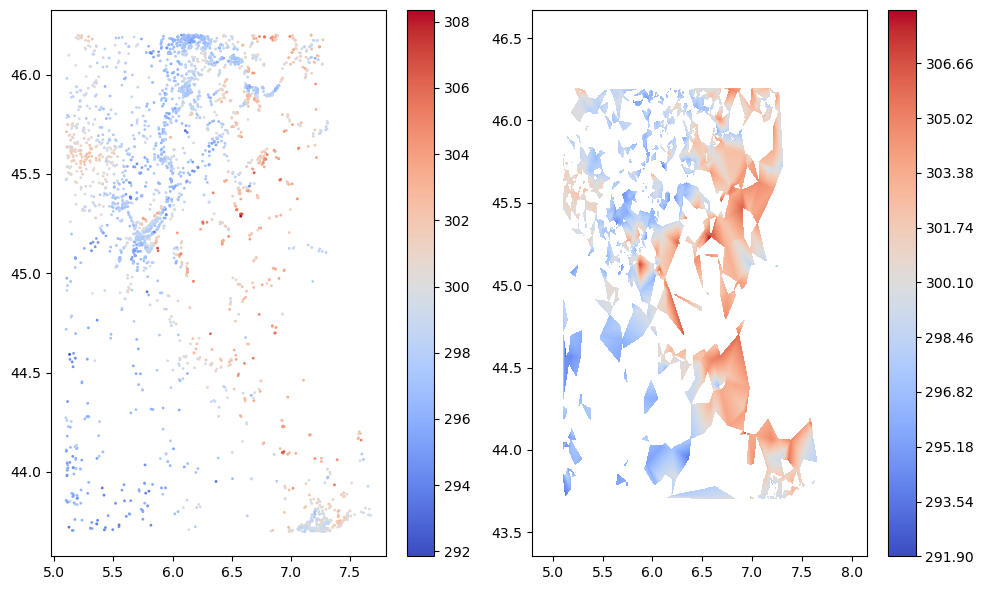

In [341]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

potential_temp(img_extent,a,df_net,'net')

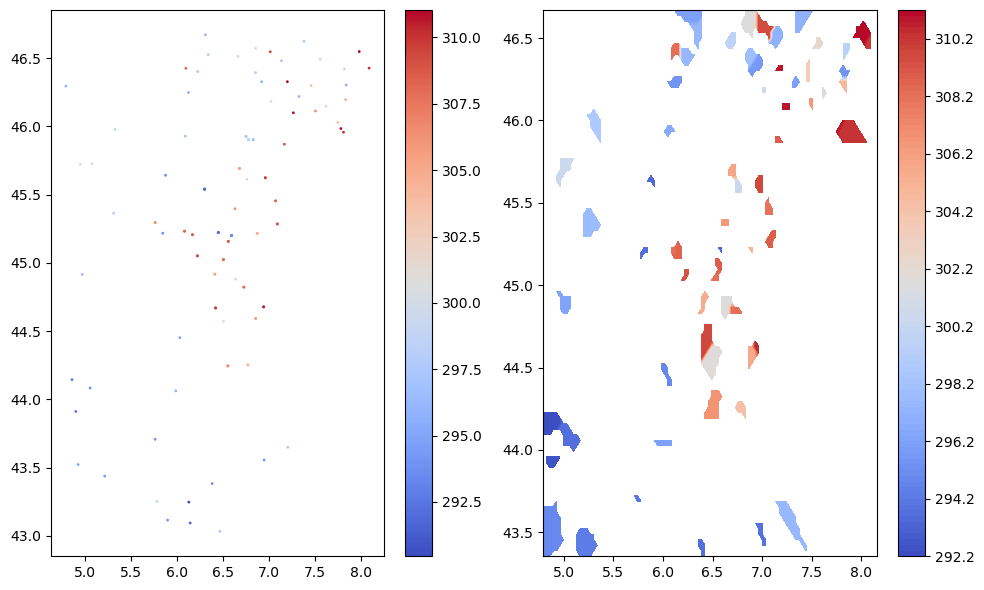

In [274]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

potential_temp(img_extent,df_mf,a,'mf')

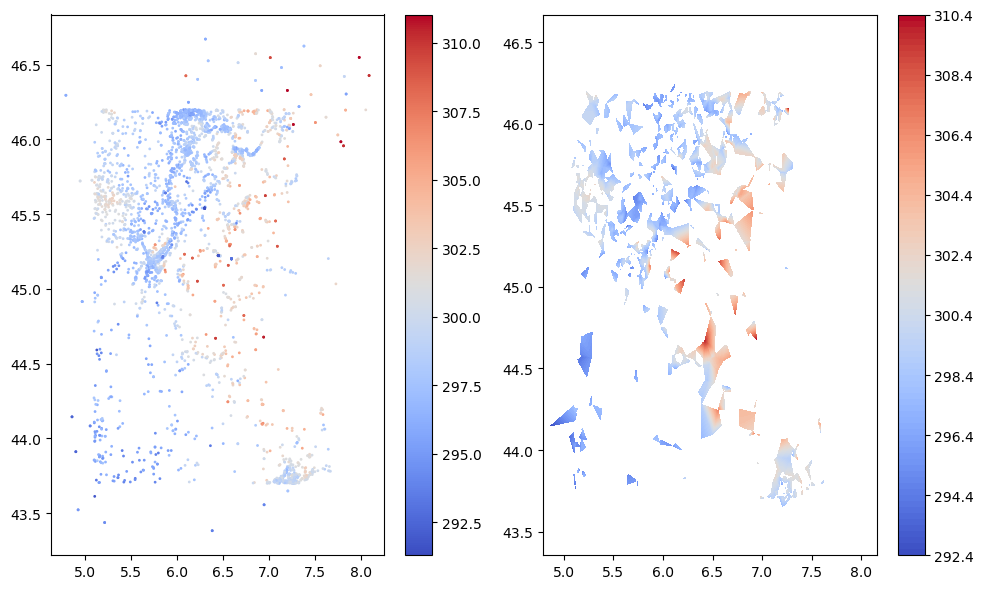

In [275]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

potential_temp(img_extent,df_mf,df_net,'both')

## Kriging

In [276]:
from skgstat.models import spherical
import skgstat

In [368]:
df_net = df_net.dropna(axis=0,thresh=10)
df_net.head(10)

,id,lon,lat,alt,Temp,hu,Tbrut,hubrut,t0,t1
2,70:ee:50:00:0a:da,5.750908,45.277225,1124.0,20.2,50.0,21.9,56.0,1.692403e+09,1.692404e+09
4,70:ee:50:00:0c:14,5.179655,45.613582,228.0,25.5,39.0,25.6,41.0,1.692403e+09,1.692404e+09
6,70:ee:50:00:0d:9a,7.278334,43.724724,112.0,25.2,53.0,24.6,56.0,1.692403e+09,1.692404e+09
8,70:ee:50:00:0e:3a,5.677595,45.676047,237.0,22.1,56.0,21.9,66.0,1.692403e+09,1.692404e+09
18,70:ee:50:00:16:fa,6.608075,46.012272,642.0,20.3,51.0,22.2,46.0,1.692403e+09,1.692404e+09
20,70:ee:50:00:17:fe,6.237484,46.191136,440.0,19.4,53.0,24.3,40.0,1.692403e+09,1.692404e+09
23,70:ee:50:00:1e:b6,6.495865,46.065201,496.0,20.3,50.0,24.2,39.0,1.692403e+09,1.692404e+09
25,70:ee:50:00:1f:2e,6.631234,45.893051,1130.0,21.4,44.0,22.6,44.0,1.692403e+09,1.692404e+09
27,70:ee:50:00:20:7a,6.218016,46.144738,579.0,19.3,55.0,19.7,50.0,1.692403e+09,1.692404e+09
28,70:ee:50:00:23:8e,6.095180,46.186240,417.0,20.5,59.0,21.2,58.0,1.692403e+09,1.692404e+09


In [399]:
V = skgstat.Variogram(df_net[['lon','lat']], df_net.Temp.values,
              maxlag=10, n_lags=50, model='exponential', normalize=False)

C:\Users\barroisl\.conda\envs\barbapapa\Lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


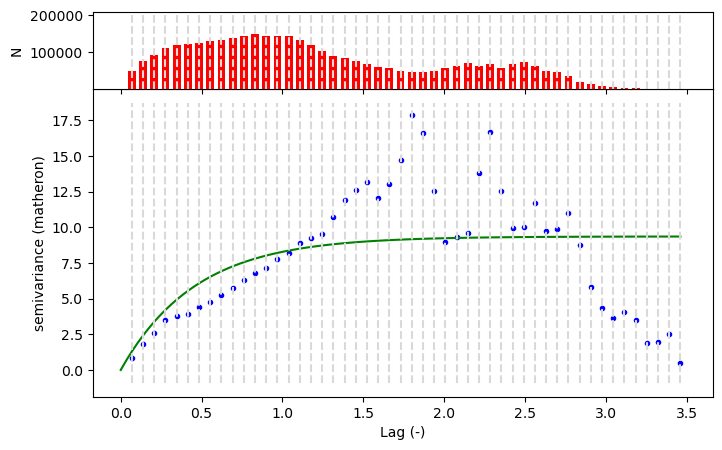

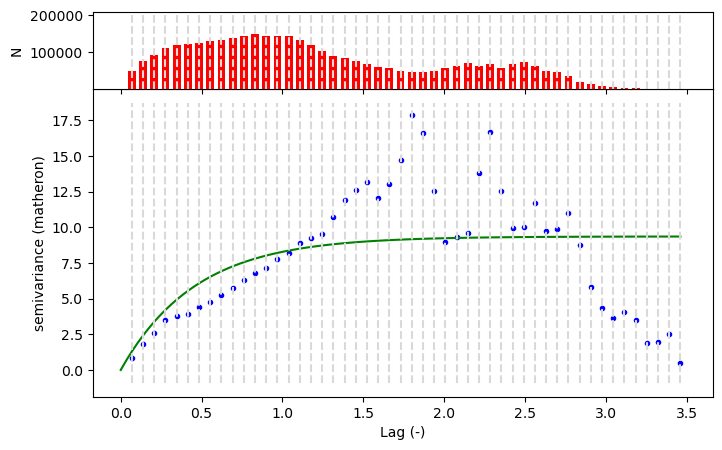

In [400]:
V.plot()

In [401]:
from skgstat import OrdinaryKriging

In [408]:
ok = OrdinaryKriging(V, min_points=5, max_points=50, mode='exact')

In [409]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

xx, yy = np.mgrid[img_extent[0]:img_extent[1]:100j, img_extent[2]:img_extent[3]:100j]

In [410]:
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)

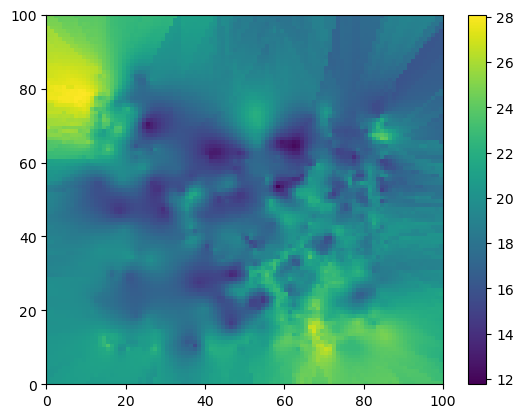

In [411]:
s2 = ok.sigma.reshape(xx.shape)
plt.pcolormesh(field)
plt.colorbar()

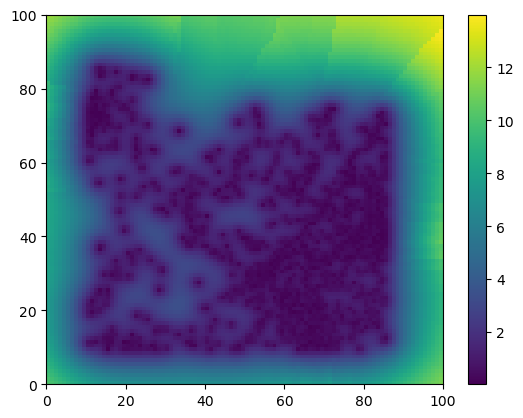

In [412]:
plt.pcolormesh(s2)
plt.colorbar()